In [1]:
# importing relevant libraries
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score
from sklearn.model_selection import train_test_split
import warnings
import re
import string
warnings.filterwarnings('ignore')

C:\Users\ACER\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [9]:
df = pd.read_csv('spam.csv')
df.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [10]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [11]:
df.shape

(5572, 5)

In [12]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4',],axis=1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
df['Spam']=df['v1'].apply(lambda x:1 if x=='spam' else 0)
df.head(5)

,v1,v2,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [14]:
from tensorflow.keras.layers import TextVectorization

In [15]:
x = df['v2']
y = df['Spam']

In [16]:
max_features = 200000
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=1800, output_mode='int')

In [17]:
vectorizer.adapt(x.values)
vect_text = vectorizer(x.values)

In [18]:
vect_text

<tf.Tensor: shape=(5572, 1800), dtype=int64, numpy=
array([[  47,  445, 6997, ...,    0,    0,    0],
       [  49,  316, 1503, ...,    0,    0,    0],
       [  51,  469,   10, ...,    0,    0,    0],
       ...,
       [6074,   62,   10, ...,    0,    0,    0],
       [   6,  500,  111, ...,    0,    0,    0],
       [2389,   42,  478, ...,    0,    0,    0]], dtype=int64)>

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((vect_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [20]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [22]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(max_features+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                        

In [25]:
history = model.fit(train, epochs=4, validation_data=val)

Epoch 1/4
244/244 [==============================] - 239s 955ms/step - loss: 0.1623 - val_loss: 0.0385
Epoch 2/4
244/244 [==============================] - 242s 992ms/step - loss: 0.0426 - val_loss: 0.0243
Epoch 3/4
244/244 [==============================] - 237s 972ms/step - loss: 0.0162 - val_loss: 0.0044
Epoch 4/4
244/244 [==============================] - 238s 976ms/step - loss: 0.0089 - val_loss: 0.0010


<Figure size 576x360 with 0 Axes>

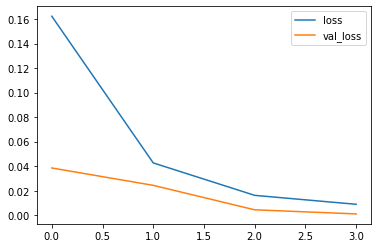

In [26]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [27]:
batch_X, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 1s 967ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1]])

In [28]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [29]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 148ms/step
Precision: 1.0, Recall:0.9838709831237793, Accuracy:0.7647058963775635


In [30]:
model.save('spam.h5')

### Let's Try Simple Classification Algorithms

In [52]:
# let's define a function for text processing
import re
import string
def text_process(text):
    text = text.lower()
    text = re.sub('\[.*/?\]', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '' ,text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '' ,text)
    text = re.sub('\n', '' ,text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [53]:
x = x.apply(text_process)

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3)

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
vector = TfidfVectorizer()
xv_train = vector.fit_transform(x_train)
xv_test = vector.transform(x_test)

In [56]:
Lr = LogisticRegression()
Lr.fit(xv_train, y_train)

LogisticRegression()

In [57]:
pred = Lr.predict(xv_test)
Lr.score(xv_test, y_test)

0.9688995215311005

In [58]:
# Let's try multiple algorithms to see which performs best
#Creating a function within many Machine Learning Models
def models(xv_train,y_train):
  
    #Using Logistic Regression Algorithm to the Training Set
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression()
    log.fit(xv_train, y_train)

    #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier()
    knn.fit(xv_train,y_train)

    #Using SVC method of svm class to use Kernel SVM Algorithm
    from sklearn.svm import SVC
    svc_rbf = SVC()
    svc_rbf.fit(xv_train, y_train)

    #Using XGBoost Algorithm
    from sklearn.ensemble import AdaBoostClassifier
    ada = AdaBoostClassifier()
    ada.fit(xv_train, y_train)

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier()
    tree.fit(xv_train, y_train)

    #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier()
    forest.fit(xv_train, y_train)

    #print model accuracy on the training data.
    print('[0]Logistic Regression Training Accuracy:', log.score(xv_train, y_train))
    print('[1]K Nearest Neighbor Training Accuracy:', knn.score(xv_train, y_train))
    print('[2]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(xv_train, y_train))
    print('[3]Ada Boost Training Accuracy:', ada.score(xv_train, y_train))
    print('[4]Decision Tree Classifier Training Accuracy:', tree.score(xv_train, y_train))
    print('[5]Random Forest Classifier Training Accuracy:', forest.score(xv_train, y_train))

    return log, knn, svc_rbf, ada, tree, forest

In [59]:
model = models(xv_train,y_train)

[0]Logistic Regression Training Accuracy: 0.9756410256410256
[1]K Nearest Neighbor Training Accuracy: 0.9402564102564103
[2]Support Vector Machine (RBF Classifier) Training Accuracy: 0.9964102564102564
[3]Ada Boost Training Accuracy: 0.9797435897435898
[4]Decision Tree Classifier Training Accuracy: 0.9997435897435898
[5]Random Forest Classifier Training Accuracy: 0.9994871794871795


In [60]:
for i in range(len(model)):
    cm = confusion_matrix(y_test, model[i].predict(xv_test)) 
    #extracting TN, FP, FN, TP
    TN, FP, FN, TP = confusion_matrix(y_test, model[i].predict(xv_test)).ravel()
    print(cm)
    print('Model[{}] Testing Accuracy = "{} !"'.format(i,  (TP + TN) / (TP + TN + FN + FP)))
    print()

[[1456    5]
 [  47  164]]
Model[0] Testing Accuracy = "0.9688995215311005 !"

[[1461    0]
 [ 128   83]]
Model[1] Testing Accuracy = "0.9234449760765551 !"

[[1457    4]
 [  31  180]]
Model[2] Testing Accuracy = "0.979066985645933 !"

[[1434   27]
 [  34  177]]
Model[3] Testing Accuracy = "0.9635167464114832 !"

[[1428   33]
 [  33  178]]
Model[4] Testing Accuracy = "0.9605263157894737 !"

[[1459    2]
 [  40  171]]
Model[5] Testing Accuracy = "0.9748803827751196 !"



In [66]:
xv = vector.fit_transform(x)

In [62]:
# Regularization Random Forest Classifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {'criterion':['gini', 'entropy', 'log_loss'],
             'n_estimators':list(range(10,100)),
             'max_features':['sqrt', 'log2']}
rf = RandomForestClassifier()
clf = GridSearchCV(rf,parameters)
clf.fit(xv_train,y_train)
print(clf.best_params_)

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 53}


In [67]:
rf = RandomForestClassifier(criterion='gini',max_features='log2', n_estimators=67)
rf.fit(xv_train,y_train)
rf.score(xv_train,y_train)
pred_dec = rf.predict(xv_test)

rfs = accuracy_score(y_test, pred_dec)
print(rfs*100)

rfscore = cross_val_score(rf,xv,y,cv=5)
rfc = rfscore.mean()
print(rfc*100)

96.77033492822966
96.8593280788336


In [68]:
# Regularization Logistic Regression
from sklearn.linear_model import LogisticRegression
parameters = {'fit_intercept':[True,False],
             'intercept_scaling':list(range(1,10)),
             'penalty':['l1', 'l2', 'elasticnet', 'none']}
lr = LogisticRegression()
clf = GridSearchCV(lr,parameters)
clf.fit(xv_train,y_train)
print(clf.best_params_)

{'fit_intercept': False, 'intercept_scaling': 1, 'penalty': 'none'}


In [69]:
lr = LogisticRegression(fit_intercept:='l2', intercept_scaling=1)
lr.fit(xv_train,y_train)
lr.score(xv_train,y_train)
pred_dec = lr.predict(xv_test)

lrs = accuracy_score(y_test, pred_dec)
print(lrs*100)

lrscore = cross_val_score(lr,xv,y,cv=5)
lrc = lrscore.mean()
print(lrc*100)

96.88995215311004
96.33892328376714


In [70]:
# Regularization Adaboost Classifier
from sklearn.ensemble import AdaBoostClassifier
parameters = {'learning_rate':[0.001,0.01,0.1,1.0,10],
             'n_estimators':[0.001,0.01, 0.1,1.0,10],
             'random_state':list(range(1,100))}
ab = AdaBoostClassifier()
clf = GridSearchCV(ab,parameters)
clf.fit(xv_train,y_train)
print(clf.best_params_)

{'learning_rate': 1.0, 'n_estimators': 10, 'random_state': 1}


In [71]:
ab = AdaBoostClassifier(learning_rate=1.0,random_state=1,n_estimators=10)
ab.fit(xv_train,y_train)
ab.score(xv_train,y_train)
pred_dec = ab.predict(xv_test)

absc = accuracy_score(y_test, pred_dec)
print(absc*100)

abscore = cross_val_score(ab,xv,y,cv=5)
abc = abscore.mean()
print(abc*100)

94.31818181818183
94.04149390955713


In [72]:
# Regularization Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
parameters = {'splitter':['best', 'random'],
             'min_samples_split':list(range(1,10)),
             'criterion':['gini', 'entropy', 'log_loss']}
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt,parameters)
clf.fit(xv_train,y_train)
print(clf.best_params_)

{'criterion': 'entropy', 'min_samples_split': 3, 'splitter': 'random'}


In [73]:
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=3, splitter='random')
dt.fit(xv_train,y_train)
dt.score(xv_train,y_train)
pred_dec = dt.predict(xv_test)

dtsc = accuracy_score(y_test, pred_dec)
print(dtsc*100)

dtscore = cross_val_score(dt,xv,y,cv=5)
dtc = dtscore.mean()
print(dtc*100)

96.41148325358851
96.33866565763097


In [74]:
# Regularization Support Vector Machine
from sklearn.svm import SVC

parameters = {'random_state': list(range(1,100)),
             'kernel':['poly', 'rbf', 'sigmoid'],
             'gamma':['scale', 'auto']}
svc = SVC()
clf = GridSearchCV(svc,parameters)
clf.fit(xv_train,y_train)
print(clf.best_params_)

{'gamma': 'scale', 'kernel': 'sigmoid', 'random_state': 1}


In [78]:
svc = SVC(gamma='scale', kernel='sigmoid', random_state=1)
svc.fit(xv_train,y_train)
svc.score(xv_train,y_train)
pred_dec = svc.predict(xv_test)

svsc = accuracy_score(y_test, pred_dec)
print(svsc*100)

svscore = cross_val_score(svc,xv,y,cv=5)
svs = svscore.mean()
print(svs*100)

98.44497607655502
98.24117026672357


In [76]:
# Regularization K Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier
parameters = {'weights':['uniform', 'distance'],
             'n_neighbors':list(range(1,10)),
             'algorithm':['auto', 'ball_tree', 'kd_tree','brute']}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn,parameters)
clf.fit(xv_train,y_train)
print(clf.best_params_)

{'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'distance'}


In [79]:
knn = KNeighborsClassifier(algorithm='auto',n_neighbors=9, weights='distance')
knn.fit(xv_train,y_train)
knn.score(xv_train,y_train)
pred_dec = dt.predict(xv_test)

knnc = accuracy_score(y_test, pred_dec)
print(knnc*100)

knnscore = cross_val_score(knn,xv,y,cv=5)
knc = knnscore.mean()
print(knc*100)

96.41148325358851
95.74683401631094


In [ ]:
# saving the best model
import pickle
pickle.dump(svc, open('hrattrition.pkl','wb'))